In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions.import_dmr import *
import pickle

In [2]:
save = False
load = True

In [3]:
# esmr_data = read_esmr(save=save, load=load)
unique_parameter_codes = pd.read_csv('processed_data/dmr_esmr_ir_mapping.csv')['PARAMETER_CODE'].unique()

In [4]:
slope_threshold = 0.05
limit_threshold = 0.1
fraction_threshold = 0.5

def create_facility_dict(data_dict):
    """
    Create a subset of the data_dict for each facility (from NPDES/DMR list)for each year in the analysis range.
    For each facility, calculate the percentage of reports for each parameter which are within the buffer % of the limit.
    """
    facility_dict = {}
    current_year = 2023

    # # Pre-filter the data for selected pollutants
    filtered_data_dict = {year: data_dict[current_year][data_dict[year]['PARAMETER_CODE'].isin(unique_parameter_codes)] for year in analysis_range}

    count = 0
    for NPDES_code in data_dict[current_year]['EXTERNAL_PERMIT_NMBR'].unique():
        count += 1
        if count % 50 == 0:
            print(f'{count} facilities processed')
        facility_dict[NPDES_code] = {}
        for parameter_code in unique_parameter_codes:
            master_pollutant_data = []
            percent_near_exceedance = {}
            
            for year in analysis_range:
                # if the parameter_code is not in the data_dict for that year, skip it
                if parameter_code not in filtered_data_dict[year]['PARAMETER_CODE'].unique():
                    continue
                else:
                    year_pollutant_data = filtered_data_dict[year][(data_dict[year]['EXTERNAL_PERMIT_NMBR'] == NPDES_code) & (filtered_data_dict[year]['PARAMETER_CODE'] == parameter_code)]
                    master_pollutant_data.append(year_pollutant_data)
                    if len(year_pollutant_data) > 0:
                        percent_of_limit = year_pollutant_data['DMR_VALUE_STANDARD_UNITS'] / year_pollutant_data['LIMIT_VALUE_STANDARD_UNITS']
                        qualifier = year_pollutant_data['LIMIT_VALUE_QUALIFIER_CODE'].iloc[0]
                        if qualifier in ['<=', '<']:
                            percent_near_exceedance[year] = len(percent_of_limit[percent_of_limit > (1 - limit_threshold)]) / len(percent_of_limit)
                        elif qualifier in ['>=', '>']:
                            percent_near_exceedance[year] = len(percent_of_limit[percent_of_limit < (1 + limit_threshold)]) / len(percent_of_limit)
                    else:
                        percent_near_exceedance[year] = 0
            
            master_pollutant_data_df = pd.concat(master_pollutant_data, ignore_index=True)
            date = pd.to_numeric(master_pollutant_data_df['MONITORING_PERIOD_END_DATE_NUMERIC'], errors='coerce')
            datetimes = master_pollutant_data_df['MONITORING_PERIOD_END_DATE']
            values = pd.to_numeric(master_pollutant_data_df['DMR_VALUE_STANDARD_UNITS'], errors='coerce')
            
            if datetimes.max().year <= 2022:
                date = []
                datetimes = []
                values = []

            if len(date) > 1:
                slope, intercept = np.polyfit(date, values, 1)
            else:
                slope = 0
                intercept = 0
            
            facility_dict[NPDES_code][parameter_code] = {
                'percent_near_exceedance': percent_near_exceedance,
                'slope': slope,
                'intercept': intercept,
                'data': master_pollutant_data_df,
                'slope_dates': date,
                'slope_datetimes': master_pollutant_data_df['MONITORING_PERIOD_END_DATE'],
                'slope_values': values,
                'slope_intercept': intercept,
                'limits': pd.to_numeric(master_pollutant_data_df['LIMIT_VALUE_STANDARD_UNITS'], errors='coerce'),
                'qualifiers': master_pollutant_data_df['LIMIT_VALUE_QUALIFIER_CODE'].values
            }
        
    return facility_dict

In [31]:
if save:  # save facility_dict and data_dict to file
    data_dict = read_all_dmrs(save=save, load=load)
    facility_dict = create_facility_dict(data_dict)
    with open('processed_data/facility_dict.pkl', 'wb') as f:
        pickle.dump(facility_dict, f)
    with open('processed_data/data_dict.pkl', 'wb') as f:
        pickle.dump(data_dict, f)
if load:
    facility_dict = pickle.load(open('processed_data/facility_dict.pkl', 'rb'))
    data_dict = read_all_dmrs(save=save, load=load)

# print the combined length of data_dict[analysis_range]
sum = 0
for year in analysis_range:
    sum += len(data_dict[year])
print(f'{sum:,} DMR events in data_dict')

483,111 DMR events in data_dict


In [6]:
facilities_with_slope, facilities_with_near_exceedance = [], []
for NPDES_code in data_dict[2023]['EXTERNAL_PERMIT_NMBR'].unique():
    for parameter_code in unique_parameter_codes:
        for year in analysis_range:
            slope = facility_dict[NPDES_code][str(parameter_code)]['slope']
            intercept = facility_dict[NPDES_code][str(parameter_code)]['intercept']
            percent_near_exceedance = facility_dict[NPDES_code][str(parameter_code)]['percent_near_exceedance']
            master_pollutant_data_df = facility_dict[NPDES_code][str(parameter_code)]['data']
            date = facility_dict[NPDES_code][str(parameter_code)]['slope_dates']
            values = facility_dict[NPDES_code][str(parameter_code)]['slope_values']
            limits = facility_dict[NPDES_code][str(parameter_code)]['limits']
            qualifiers = facility_dict[NPDES_code][str(parameter_code)]['qualifiers']
    
        # Check for facilities with significant slope based on qualifier
        if len(qualifiers) > 0:
            if qualifiers[0] in ['<=', '<'] and slope > slope_threshold:
                facilities_with_slope.append((NPDES_code, parameter_code, limits[0]))
            elif qualifiers[0] in ['>=', '>'] and slope < -slope_threshold:
                facilities_with_slope.append((NPDES_code, parameter_code, limits[0]))
        
        # Check for facilities with near exceedance
        if any(percent_near_exceedance[year] > 0.5 for year in analysis_range):
            facilities_with_near_exceedance.append((NPDES_code, parameter_code, limits[0]))
facilities_with_slope_and_near_exceedance = list(set(facilities_with_slope) & set(facilities_with_near_exceedance))

In [7]:
print(f'{len(facilities_with_slope)} facility-parameter pairs with slope > {slope_threshold*100}%')
print(f'{len(facilities_with_near_exceedance)} facility-parameter pairs with near exceedance > {limit_threshold*100}% of limit more than {fraction_threshold*100}% of the time')
print(f'{len(facilities_with_slope_and_near_exceedance)} facility-parameter pairs with both slope and near exceedance')
facilities_with_slope_and_near_exceedance_df = pd.DataFrame(facilities_with_slope_and_near_exceedance, columns=['NPDES_CODE', 'PARAMETER_CODE', 'LIMIT_VALUE_STANDARD_UNITS'])

679 facility-parameter pairs with slope > 5.0%
537 facility-parameter pairs with near exceedance > 10.0% of limit more than 50.0% of the time
80 facility-parameter pairs with both slope and near exceedance


### Plot timeseries for each facility-parameter combination

In [8]:
facilities_grouped = facilities_with_slope_and_near_exceedance_df.groupby('NPDES_CODE')

# Loop through each facility (NPDES_CODE) with at least one parameter with slope and near exceedance
for NPDES_CODE, group in facilities_grouped:
    num_parameters = len(group)
    fig, axs = plt.subplots(num_parameters, 1, figsize=(6, 2*num_parameters), sharex=True)
    fig.suptitle(f'Facility: {NPDES_CODE}', fontsize=16)
    
    for idx, (_, row) in enumerate(group.iterrows()):
        PARAMETER_CODE, LIMIT_VALUE = str(row['PARAMETER_CODE']), row['LIMIT_VALUE_STANDARD_UNITS']
        facility_data = facility_dict[NPDES_CODE][PARAMETER_CODE]
        parameter_desc = ref_parameter.loc[ref_parameter['PARAMETER_CODE'] == PARAMETER_CODE, 'PARAMETER_DESC'].values[0]
        qualifier = facility_data['qualifiers'][0]

        ax = axs[idx] if num_parameters > 1 else axs
        
        # plot data points
        ax.scatter(facility_data['slope_dates'], facility_data['slope_values'], label='Data')
        
        # plot trend line
        x = np.array(facility_data['slope_dates'])
        y = facility_data['intercept'] + facility_data['slope'] * x
        r2 = np.corrcoef(facility_data['slope_values'], y)[0, 1]**2
        ax.plot(x, y, 'k--', label=f'Trend (Slope: {facility_data["slope"]:.2f}, R²: {r2:.2f})')
        
        # shade areas above/below limit based on qualifier
        ylim = ax.get_ylim()
        if '>' in qualifier:
            ax.fill_between(x, LIMIT_VALUE, ylim[1], color='lightgreen', alpha=0.3, label='In Compliance')
            ax.fill_between(x, ylim[0], LIMIT_VALUE, color='lightcoral', alpha=0.3, label='Out of Compliance')
        elif '<' in qualifier:
            ax.fill_between(x, ylim[0], LIMIT_VALUE, color='lightgreen', alpha=0.3, label='In Compliance')
            ax.fill_between(x, LIMIT_VALUE, ylim[1], color='lightcoral', alpha=0.3, label='Out of Compliance')

        ax.set_ylabel('Value')
        ax.legend(loc='upper right', frameon=False, bbox_to_anchor=(2, 0.9))    
        ax.set_title(f'{parameter_desc}')

    fig.text(0.5, 0.04, 'Date', ha='center') # set common x-label

    # handles, labels = ax.get_legend_handles_labels()
    # fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.91, 0.7), frameon=False)
    plt.tight_layout()
    plt.subplots_adjust(right=0.6, bottom=0.1)
    plt.savefig(f'processed_figures/slope_and_near_exceedence/{NPDES_CODE}.png')
    plt.close()

## Barplot of facilities frequently above limits

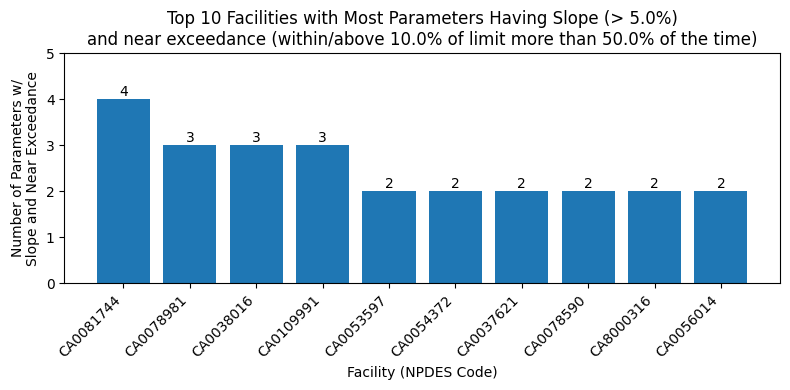

In [9]:
buffer_values = [limit_threshold]

# Count the number of parameters for each facility with slope and near exceedance
num_parameters_per_facility = {}
for facility, parameter_code, _ in facilities_with_slope_and_near_exceedance:
    if facility not in num_parameters_per_facility:
        num_parameters_per_facility[facility] = set()
    num_parameters_per_facility[facility].add(parameter_code)

# Convert sets to counts
num_parameters_per_facility = {facility: len(parameters) for facility, parameters in num_parameters_per_facility.items()}

# Sort facilities by number of parameters and get top 10
top_10_facilities = dict(sorted(num_parameters_per_facility.items(), key=lambda x: x[1], reverse=True)[:10])

# Prepare data for plotting
facilities = list(top_10_facilities.keys())
parameter_counts = list(top_10_facilities.values())

# Plot the top 10 facilities
plt.figure(figsize=(8, 4))
bars = plt.bar(facilities, parameter_counts)
plt.xlabel('Facility (NPDES Code)')
plt.ylabel('Number of Parameters w/\nSlope and Near Exceedance')
plt.title(f'Top 10 Facilities with Most Parameters Having Slope (> {slope_threshold*100}%)\nand near exceedance (within/above {limit_threshold*100}% of limit more than {fraction_threshold*100}% of the time)')
plt.xticks(rotation=45, ha='right')
plt.yticks(range(max(parameter_counts) + 2))

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()
    

In [10]:
# make a df with NPDES_CODE and the number of parameters with slope and near exceedance
df = pd.DataFrame(list(num_parameters_per_facility.items()), columns=['NPDES_CODE', 'num_parameters'])
df = df.merge(pd.DataFrame({'NPDES_CODE': data_dict[2023]['EXTERNAL_PERMIT_NMBR'].unique()}), on='NPDES_CODE', how='right') # add 0 for other facilities
df['num_parameters'] = df['num_parameters'].fillna(0)
df.to_csv('processed_data/num_parameters_per_facility.csv', index=False)

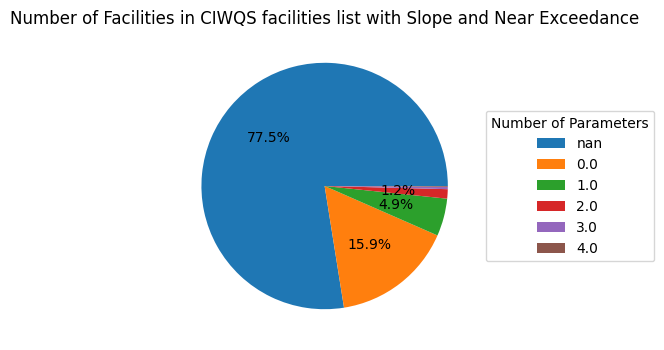

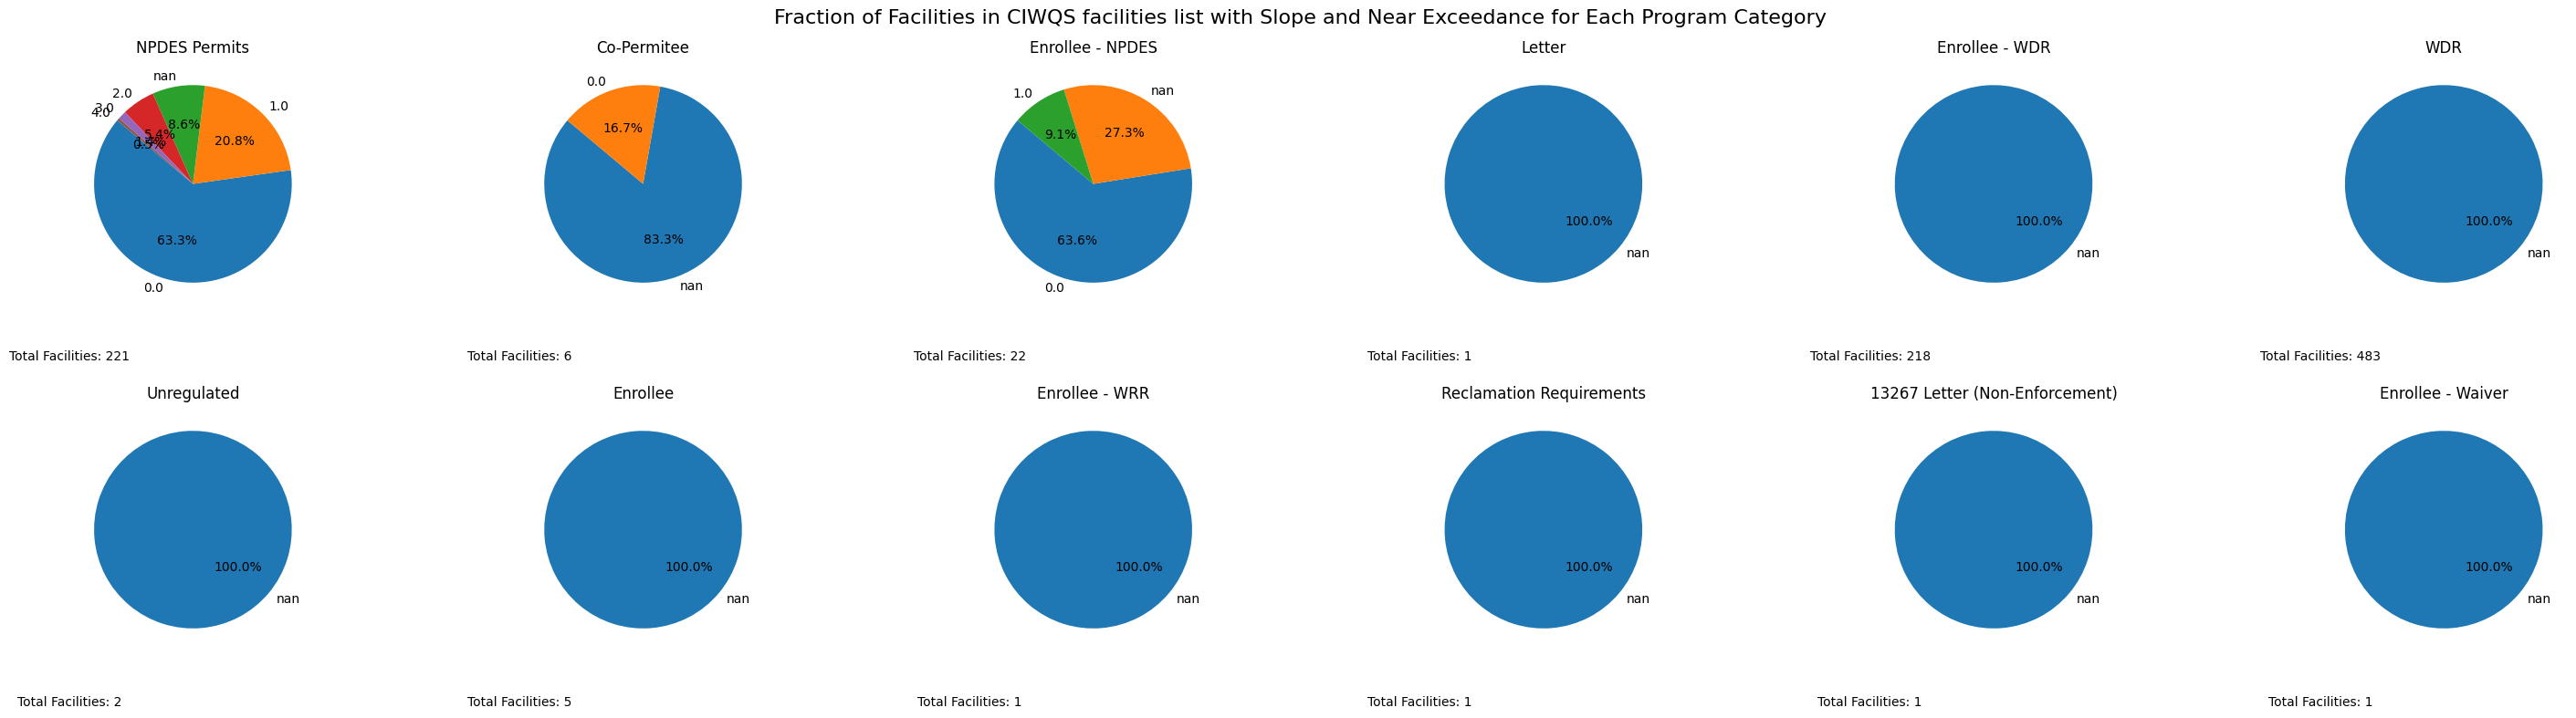

In [11]:
# import ciwqs_facilities and merge df into ciwqs_facilities based on NPDES_CODE
ciwqs_facilities = pd.read_csv('data/facilities_list/NPDES+WDR Facilities List_20240906.csv')
ciwqs_facilities = ciwqs_facilities.merge(df, left_on='NPDES # CA#', right_on='NPDES_CODE', how='left')
ciwqs_facilities.to_csv('processed_data/ciwqs_facilities.csv', index=False)

def autopct_format(pct):
    return ('%1.1f%%' % pct) if pct > 1 else ''
plt.figure(figsize=(5, 4))
value_counts = ciwqs_facilities['num_parameters'].value_counts(dropna=False)
wedges, texts, autotexts = plt.pie(value_counts.values, autopct=autopct_format)
plt.legend(wedges, value_counts.index, title="Number of Parameters", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Number of Facilities in CIWQS facilities list with Slope and Near Exceedance')
plt.show()

# Get unique program categories
program_categories = ciwqs_facilities[ciwqs_facilities['REG MEASURE TYPE'].notna()]['REG MEASURE TYPE'].unique()
n_cols = (len(program_categories) + 1) // 2
fig, axs = plt.subplots(2, n_cols, figsize=(5*n_cols, 8), squeeze=False)
fig.suptitle('Fraction of Facilities in CIWQS facilities list with Slope and Near Exceedance for Each Program Category', fontsize=16)
axs_flat = axs.flatten()
for idx, program_category in enumerate(program_categories):
    category_facilities = ciwqs_facilities[ciwqs_facilities['REG MEASURE TYPE'] == program_category]
    value_counts = category_facilities['num_parameters'].value_counts(dropna=False)
    axs_flat[idx].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    axs_flat[idx].set_title(f'{program_category}')
    axs_flat[idx].text(0, -0.2, f'Total Facilities: {len(category_facilities)}', ha='center', va='center', transform=axs_flat[idx].transAxes)
for idx in range(len(program_categories), len(axs_flat)):
    fig.delaxes(axs_flat[idx])
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # Increase vertical space between subplots
plt.show()


### Print the facilities that do not show up with any parameters having slope and near exceedance

In [32]:
unique_facilities = ciwqs_facilities[~ciwqs_facilities['NPDES # CA#'].isin(df['NPDES_CODE'])][['FACILITY ID', 'FACILITY NAME', 'WDID', 'NPDES # CA#']].drop_duplicates()
print(f'{len(unique_facilities)} facilities in CIWQS facilities list do not have a match in data_dict')
# print(unique_facilities.to_string(index=False)) # uncomment to print the facilities

755 facilities in CIWQS facilities list do not have a match in data_dict


In [23]:
## Print the most frequent parameter codes and their corresponding descriptions with value counts
dmr_esmr_ir_mapping = pd.read_csv('processed_data/dmr_esmr_ir_mapping.csv')
most_frequent_parameter_codes = facilities_with_slope_and_near_exceedance_df['PARAMETER_CODE'].value_counts()

for code, value_count in most_frequent_parameter_codes.items():
    desc = dmr_esmr_ir_mapping.loc[dmr_esmr_ir_mapping['PARAMETER_CODE'] == code, 'ESMR_PARAMETER_DESC'].values
    if len(desc) > 0:
        if desc[0] == 'No Match':
            parameter_desc = dmr_esmr_ir_mapping.loc[dmr_esmr_ir_mapping['PARAMETER_CODE'] == code, 'DMR_PARAMETER_DESC'].values[0]
            print(f'No Match: {value_count}')
            print(f'    DMR: {parameter_desc}')
        else:
            print(f'{desc[0]}: {value_count}')
    else:
        print(f'Unknown parameter (code {code}): {value_count}')


pH: 12
Chlorine, Total Residual: 9
BOD5 @ 20 Deg. C, Percent Removal: 9
Total Suspended Solids (TSS), Percent Removal: 9
Total Coliform: 7
No Match: 5
    DMR: Specific conductance
Total Suspended Solids (TSS): 4
Biochemical Oxygen Demand (BOD) (5-day @ 20 Deg. C): 3
Nitrate, Total (as N): 2
Radiation, Gross Beta: 2
Ammonia, Total (as N): 2
Total Dissolved Solids (TDS): 2
Oil and Grease: 2
Chloride: 1
No Match: 1
    DMR: Temperature Increase Deg. F
Nitrite Plus Nitrate (as N): 1
No Match: 1
    DMR: Di[2-ethylhexyl] phthalate [DEHP]
Fecal Coliform: 1
Total Organic Carbon (TOC), Percent Removal: 1
Temperature: 1
Radiation, Gross Beta: 1
Nitrogen, Total (as N): 1
Turbidity: 1
Turbidity: 1
Flow: 1
